**Calculating the Products with high Dip**

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [0]:
df = spark.read.csv("dbfs:/FileStore/salesdata/4_final_data.csv", header=True, inferSchema=True, multiLine=True)

In [0]:
#df.display()

In [0]:
df_pr_dip = df.select("Order Date", "Product Name", "Sales").\
    withColumn("Order Year",year(col("Order Date"))).\
        withColumn("Order Month",month(col("Order Date")))

In [0]:
#df_pr_dip.display()

In [0]:
#df_pr_dip = df_pr_dip.groupBy("Order Date","Product Name").agg(avg("Sales"))

'''windowSpec = Window.partitionBy("Product Name").orderBy("Order Year", "Order Month")

df_pr_dip = df_pr_dip.withColumn("Previous Sales", lag(col("Sales")).over(windowSpec))'''

df_pr_dip = df_pr_dip.withColumn("Year-Month",concat_ws("-",col("Order Year"),col("Order Month")))

# Aggregate average sales per "Year-Month" for each product
avg_sales_df = df_pr_dip.groupBy("Year-Month", "Product Name").agg(avg("Sales").alias("Average Sales"),count("Product Name").alias("Product Count"))

# Define Window Specification for product-wise ordering
windowSpec = Window.partitionBy("Product Name").orderBy("Year-Month")

# Compute previous month's average sales
avg_sales_df = avg_sales_df.withColumn("Previous Avg Sales", lag(col("Average Sales")).over(windowSpec))

# Compute change in average sales
dip_df = avg_sales_df.withColumn("Sales Change", round((col("Previous Avg Sales") - col("Average Sales")), 2))


# Compute percentage change
#dip_df = df_pr_dip.withColumn("Sales Change", round((col("Average Sales") - col("Previous Avg Sales")), 2))
#dip_df.display()



In [0]:
df_pr_dip.printSchema()

root
 |-- Order Date: date (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Order Year: integer (nullable = true)
 |-- Order Month: integer (nullable = true)
 |-- Year-Month: string (nullable = false)



In [0]:
# Filter rows where sales dipped (negative percentage change)
#dip_df = dip_df.filter(col("Sales Change %") < -10)  # Threshold: 10% dip

In [0]:
#dip_df.select("Order Year", "Order Month", "Product Name", "Sales", "Previous Sales", "Sales Change").orderBy("Sales Change").display()


Top 10 Products

In [0]:
#dip_df.display()

In [0]:
#dip_df = dip_df.withColumn("Year-Month",concat_ws("-",col("Order Year"),col("Order Month")))
#dip_df.display()


In [0]:
# Select top 5 products with the maximum dip (minimum Sales Change %)
top_5_dip_products = dip_df.orderBy(col("Sales Change").desc()).limit(5)

# Show the selected products
top_5_dip_products.show()

+----------+--------------------+-------------+-------------+------------------+------------+
|Year-Month|        Product Name|Average Sales|Product Count|Previous Avg Sales|Sales Change|
+----------+--------------------+-------------+-------------+------------------+------------+
|    2018-2|Microsoft Natural...|       47.904|            1|           500.641|      452.74|
|    2015-3|Global Push Butto...|       48.712|            1|           500.641|      451.93|
|    2017-4|Kensington 4 Outl...|       48.792|            1|           500.641|      451.85|
|    2017-4|Fellowes Bankers ...|       51.984|            1|           500.641|      448.66|
|    2016-4|Global Geo Office...|       56.686|            1|           500.641|      443.96|
+----------+--------------------+-------------+-------------+------------------+------------+



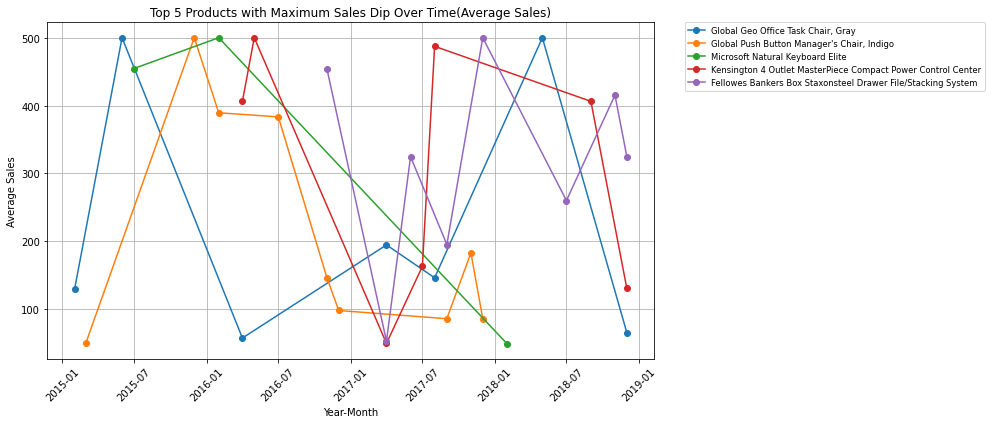

In [0]:
from pyspark.sql.functions import col, concat_ws, sum as spark_sum
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Year-Month' column exists
#dip_df = dip_df.withColumn("Year-Month", concat_ws("-", col("Order Year"), col("Order Month")))

# Select top 5 products with the maximum dip (lowest Sales Change %)
top_dip_products = dip_df.orderBy(col("Sales Change").desc()).limit(5).select("Product Name").distinct()

# Filter dataset to keep only the top 5 products
dip_top5_df = dip_df.join(top_dip_products, "Product Name")

# Aggregate total sales per 'Year-Month' for these products
#sales_trend_df = dip_top5_df.groupBy("Year-Month", "Product Name").agg(avg("Sales").alias("Average Sales"))
sales_trend_df = dip_top5_df #.groupBy("Year-Month", "Product Name").agg(avg("Sales").alias("Average Sales"))

# Convert to Pandas for plotting
sales_trend_pd = sales_trend_df.toPandas()

# Ensure 'Year-Month' is treated as a datetime format for proper sorting
sales_trend_pd["Year-Month"] = pd.to_datetime(sales_trend_pd["Year-Month"], format="%Y-%m")
sales_trend_pd = sales_trend_pd.sort_values(by=["Year-Month"])

# Plot
plt.figure(figsize=(14, 6))

for product in sales_trend_pd["Product Name"].unique():
    product_data = sales_trend_pd[sales_trend_pd["Product Name"] == product]
    plt.plot(
        product_data["Year-Month"], 
        product_data["Average Sales"], 
        marker="o", linestyle="-", label=product
    )

# Formatting
plt.xlabel("Year-Month")
plt.ylabel("Average Sales")
plt.title("Top 5 Products with Maximum Sales Dip Over Time(Average Sales)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(loc="best", fontsize="small", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [0]:
top_dip_products.display()

Product Name
Microsoft Natural Keyboard Elite
"Global Push Button Manager's Chair, Indigo"
Kensington 4 Outlet MasterPiece Compact Power Control Center
Fellowes Bankers Box Staxonsteel Drawer File/Stacking System
"Global Geo Office Task Chair, Gray"


Dip per Year

In [0]:
year_df = df.withColumn("Order Year",year(col("Order Date"))).select("Product Name","Sales","Order Year")

avg_year_df = year_df.groupBy("Order Year", "Product Name").agg(avg("Sales").alias("Average Sales"))

windowSpec = Window.partitionBy("Product Name").orderBy("Order Year")
avg_year_df = avg_year_df.withColumn("Previous Avg Sales", lag(col("Average Sales")).over(windowSpec))
dip_year_df = avg_year_df.withColumn("Sales Change", round((col("Previous Avg Sales") - col("Average Sales")), 2))

top_5_dip_year_products = dip_year_df.orderBy(col("Sales Change").desc()).limit(5)
top_5_dip_year_products.display()


Order Year,Product Name,Average Sales,Previous Avg Sales,Sales Change
2018,Microsoft Natural Keyboard Elite,47.904,500.641,452.74
2018,Eureka Sanitaire Commercial Upright,66.284,500.641,434.36
2017,Polycom SoundPoint Pro SE-225 Corded phone,118.99,500.641,381.65
2018,"Metal Folding Chairs, Beige, 4/Carton",71.274,427.644,356.37
2018,Razer Kraken 7.1 Surround Sound Over Ear USB Gaming Headset,149.98499999999999,500.641,350.66


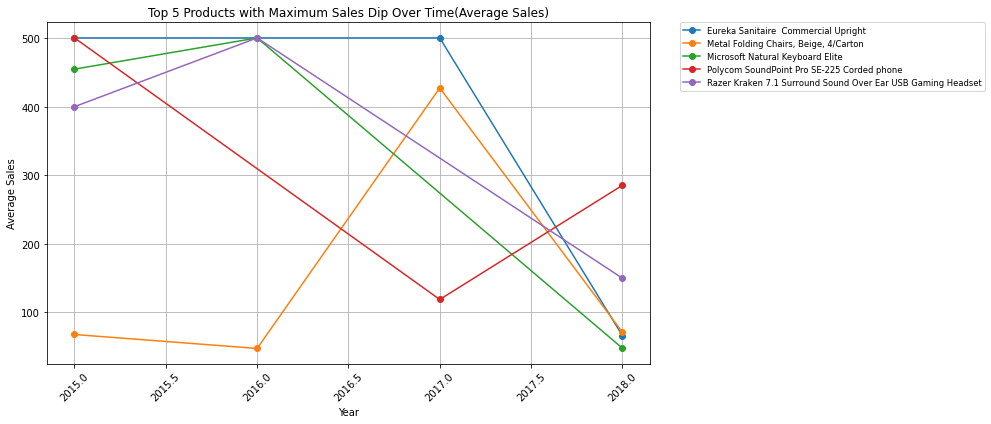

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

top_5_year_dip_products_name_df = top_5_dip_year_products.select("Product Name").distinct()
sales_trend_year_df = dip_year_df.join(top_5_year_dip_products_name_df,"Product Name")

sales_trend_year_pd = sales_trend_year_df.toPandas()
sales_trend_year_pd = sales_trend_year_pd.sort_values(by=["Order Year"])

# Plot
plt.figure(figsize=(14, 6))

for product in sales_trend_year_pd["Product Name"].unique():
    product_data = sales_trend_year_pd[sales_trend_year_pd["Product Name"] == product]
    plt.plot(
        product_data["Order Year"], 
        product_data["Average Sales"], 
        marker="o", linestyle="-", label=product
    )

# Formatting
plt.xlabel("Year")
plt.ylabel("Average Sales")
plt.title("Top 5 Products with Maximum Sales Dip Over Time(Average Sales)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(loc="best", fontsize="small", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Dip by category

In [0]:
category_df = df.withColumn("Order Year",year(col("Order Date"))).select("Sub-Category","Sales","Order Year")

category_df = category_df.groupBy("Order Year", "Sub-Category").agg(sum("Sales").alias("Total Sales"))

windowSpec = Window.partitionBy("Sub-Category").orderBy("Order Year")
category_df = category_df.withColumn("Previous Total Sales", lag(col("Total Sales")).over(windowSpec))
category_df = category_df.withColumn("Sales Change", round((col("Previous Total Sales") - col("Total Sales")), 2))

top_5_dip_category_products = category_df.orderBy(col("Sales Change").desc()).limit(5)
top_5_dip_category_products.display()


Order Year,Sub-Category,Total Sales,Previous Total Sales,Sales Change
2016,Tables,20236.37699999999,26244.865999999987,6008.49
2016,Chairs,41826.35700000001,46634.66400000005,4808.31
2017,Bookcases,16644.99599999999,20335.69899999999,3690.7
2017,Copiers,6988.316999999999,9850.199999999999,2861.88
2016,Storage,33254.298999999985,35965.948,2711.65


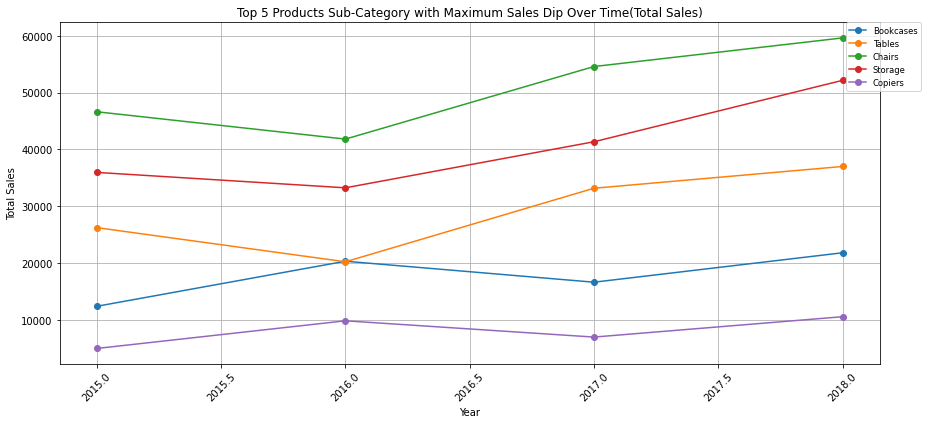

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

top_5_category_df = top_5_dip_category_products.select("Sub-Category").distinct()
sales_trend_category_df = category_df.join(top_5_category_df,"Sub-Category")

sales_trend_category_pd = sales_trend_category_df.toPandas()
sales_trend_category_pd = sales_trend_category_pd.sort_values(by=["Order Year"])


# Plot
plt.figure(figsize=(14, 6))

for product in sales_trend_category_pd["Sub-Category"].unique():
    product_data = sales_trend_category_pd[sales_trend_category_pd["Sub-Category"] == product]
    plt.plot(
        product_data["Order Year"], 
        product_data["Total Sales"], 
        marker="o", linestyle="-", label=product
    )

# Formatting
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.title("Top 5 Products Sub-Category with Maximum Sales Dip Over Time(Total Sales)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(loc="best", fontsize="small", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
